In [1]:
#! pip install numba

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit
import time
import warnings
warnings.filterwarnings("ignore")

from numba import int32, float32    # import the types
from numba.experimental import jitclass

spec = [              # a simple scalar field
    ('array', float32[:]),   
    ('value', int32)       # an array field
]

In [3]:
def alistToNumpy(lines):
    """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
    list-of-lists corresponding to the lines of the AList format, already parsed to integers
    if read from a text file.
    The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
    This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
    weights, respectively) and the row-based information (last part of the Alist file) are omitted.
    Example:
        alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
        array([[1, 0, 1],
               [0, 1, 1]])
    """
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=np.int)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix

def alist2sparse(file_H):
    with open(file_H) as f:
        lines = f.readlines()
        new_lines = []
        for line in lines:
            new_lines.append(list(map(int, line.split())))
    H_matrix = alistToNumpy(new_lines)
    return H_matrix


In [4]:
def WBEC(y):
    '''
    BEC channel
    '''
    L1=np.zeros(y.shape[0])
    L1[y < -0.5] = np.log(1)
    L1[np.abs(y) < 0.5] = np.log(10000)
    L1[y > 0.5] = np.log(0.00001)
    return L1





def WBAWGN(y,sigma):
    '''
    LLR computation AWGN channel 
    '''
    return 2* y / sigma ** 2




def Do_Test(A):
    u=np.zeros(len(A))
    for i in range(len(A)):
        if (A[i]!=-1):
            if (random.random()<0.5):
                u[i]=1
    return u




def BAWGN_ch(u,sigma):
    '''
    BAWGN channel 
    '''
    u2 = np.zeros(u.shape[0])
    u2[u == 0] = 1
    u2[u == 1] = -1
    f = np.random.normal(0, sigma, u.shape[0]) 
    u2 = f + u2
    return u2


def sigma(SNR): 
    sigma = np.sqrt(1/10**(SNR/10)/2)
    return sigma

def generate_regular_H(n,k,w):
    H = np.zeros((n-k,n))
    H[:w,0] = 1
    for i in range(1,n):
        H[:,i] = np.roll(H[:,i-1], 1)
    return H

In [5]:
class VarNode():
    def __init__(self, num, init_LLR, con_check_nodes):
        self.num = num
        self.init_LLR = init_LLR
        self.cur_message = init_LLR
        
        self.iter = 0 
        self.con_check_nodes = con_check_nodes
#         print(self.con_check_nodes)
        
    def update_message(self, check_node_messages):
        self.cur_message = 2 * np.arctanh(np.clip(check_node_messages[self.con_check_nodes] \
                                          / np.tanh(self.cur_message / 2),-0.999,0.999))
#         print(self.cur_message, self.init_LLR )
        self.cur_message = self.cur_message.sum() + self.init_LLR 
        return self.cur_message
    
    def decision(self,check_node_messages):
        self.cur_message = 2 * np.arctanh(np.clip(check_node_messages[self.con_check_nodes] \
                                          / np.tanh(self.cur_message / 2),-0.999,0.999))
#         print(self.cur_message, self.init_LLR )


        self.cur_message = self.cur_message.sum() + self.init_LLR 
        return self.cur_message, self.cur_message < 0
        
    def update_init(self, new_init_LLR):
        self.init_LLR = new_init_LLR
        self.cur_message = new_init_LLR

In [6]:
class CheckNode():
    def __init__(self, num, con_var_nodes):
        self.num = num
        self.cur_message = 0
        self.iter = 0 
        self.con_var_nodes = con_var_nodes
        
    def update_message(self, variable_node_messages):

        self.cur_message = np.prod(np.tanh((variable_node_messages[self.con_var_nodes] - self.cur_message)/2))
        
        return self.cur_message

In [7]:

            
class BP():
    def __init__(self, H, iterations):
        self.H = H
        self.var_nodes = []
        self.check_nodes = []
        self.check_nodes_ind = np.arange(H.shape[0])
        self.var_nodes_ind = np.arange(H.shape[1])
        self.iterations = iterations
        self.var_messages = np.zeros(H.shape[1])
        self.check_messages = np.zeros(H.shape[0])
        self.decision = np.zeros(H.shape[1])
        self.hard_decision = np.zeros(H.shape[1])
        for i in range(H.shape[0]):
            con_var_nodes = self.var_nodes_ind[H[i,:] == 1]
            self.check_nodes.append(CheckNode(i, con_var_nodes))
            
        for i in range(H.shape[1]):
            con_check_nodes=self.check_nodes_ind[H[:,i] == 1]
            self.var_nodes.append(VarNode(i, self.var_messages[i] ,con_check_nodes))
    
    def init_var_nodes(self, LLR):
        for v_i in range(self.H.shape[1]):
            self.var_nodes[v_i].update_init(LLR[v_i])
        
            
        
      
    def decode(self, LLR):
        self.init_var_nodes(LLR)
        self.var_messages = LLR.copy()
#         print(self.var_messages)
        
        for it in range(self.iterations - 1):
            
            for c_i in range(self.H.shape[0]):
                self.check_messages[c_i] = self.check_nodes[c_i].update_message(self.var_messages)
#             print("c", self.check_messages)
            for v_i in range(self.H.shape[1]):
                self.var_messages[v_i] = self.var_nodes[v_i].update_message(self.check_messages)
#             print("v", self.var_messages)
        for c_i in range(self.H.shape[0]):
            self.check_messages[c_i] = self.check_nodes[c_i].update_message(self.var_messages)
        for v_i in range(self.H.shape[1]):
            self.decision[v_i], self.hard_decision[v_i] = self.var_nodes[v_i].decision(self.check_messages)
            
        return self.decision, self.hard_decision           
        
        
    

In [8]:
def test_performance( SNRs, num_tests):

    H = alist2sparse("./wimax_1056_0.83.alist")
    n = H.shape[1]
    k = H.shape[1] - H.shape[0]
    u = np.zeros(H.shape[1])
    decoder = BP(H, 15)
    fer = np.zeros(SNRs.size)
    ber =  np.zeros(SNRs.size)
    fer_ch = np.zeros(SNRs.size)
    ber_ch =  np.zeros(SNRs.size)
    for i_s, snr in enumerate(SNRs):
        print(f"Testing SNR:{snr}")
        sigma__ = sigma(snr)
        for i in range(num_tests):
            if i% 5 ==0:
                print(i)
            LLR = WBAWGN(BAWGN_ch(u,sigma__),sigma__)
            sd, hd = decoder.decode(LLR)
            cur_ber = (hd.astype(int) - u).sum()
            cur_ber_ch = ((LLR < 0).astype(int) - u).sum()
            ber_ch[i_s] += cur_ber_ch
            fer_ch[i_s] += (cur_ber_ch > 0).astype(float)
            ber[i_s] += cur_ber
            fer[i_s] += (cur_ber > 0).astype(float)
    return ber / n / num_tests, fer / num_tests,  ber_ch / n / num_tests, fer_ch / num_tests
    
            

In [9]:

SNRs = np.array([1])
num_tests= 50



ber, fer, ber_ch, fer_ch = test_performance(SNRs, num_tests)



Testing SNR:1
0
5
10
15
20
25
30
35
40
45


##  Parallel 

In [10]:
# ! pip install mpi4py

In [11]:
%%file test_ldpc.py

import numpy as np
import itertools as itt
import matplotlib.pyplot as plt
import os
#from google.colab import drive
from mpi4py import MPI
import numpy as np
import time 

def alistToNumpy(lines):
    """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
    list-of-lists corresponding to the lines of the AList format, already parsed to integers
    if read from a text file.
    The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
    This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
    weights, respectively) and the row-based information (last part of the Alist file) are omitted.
    Example:
        alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
        array([[1, 0, 1],
               [0, 1, 1]])
    """
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=np.int)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix

def alist2sparse(file_H):
    with open(file_H) as f:
        lines = f.readlines()
        new_lines = []
        for line in lines:
            new_lines.append(list(map(int, line.split())))
    H_matrix = alistToNumpy(new_lines)
    return H_matrix

def split_array_interval_proc(array_len, rank, size):
    num_comp = int(array_len / size)
    red = array_len % size
    start_point = rank * num_comp
    end_point = start_point + num_comp
    if rank < red:
        start_point += rank
        end_point += rank + 1
    else:
        start_point += red
        end_point += red
    return start_point, end_point



class VarNode():
    def __init__(self, num, init_LLR, con_check_nodes):
        self.num = num
        self.init_LLR = init_LLR
        self.cur_message = init_LLR
        
        self.iter = 0 
        self.con_check_nodes = con_check_nodes
#         print(self.con_check_nodes)
        
    def update_message(self, check_node_messages):
        old_cur_message = self.cur_message
        self.cur_message = 2 * np.arctanh(np.clip(check_node_messages[self.con_check_nodes] \
                                          / np.tanh(self.cur_message / 2),-0.999,0.999))
        self.cur_message = self.cur_message.sum() + self.init_LLR
        # print(self.cur_message, self.num , self.con_check_nodes,check_node_messages[self.con_check_nodes], old_cur_message) 
        return self.cur_message
    
    def decision(self,check_node_messages):
        self.cur_message = 2 * np.arctanh(np.clip(check_node_messages[self.con_check_nodes] \
                                          / np.tanh(self.cur_message / 2),-0.999,0.999))
        # print(self.cur_message, self.num)


        self.cur_message = self.cur_message.sum() + self.init_LLR 
        return self.cur_message, self.cur_message < 0
        
    def update_init(self, new_init_LLR):
        self.init_LLR = new_init_LLR
        self.cur_message = new_init_LLR

class CheckNode():
    def __init__(self, num, con_var_nodes):
        self.num = num
        self.cur_message = 0
        self.iter = 0 
        self.con_var_nodes = con_var_nodes
        
    def update_message(self, variable_node_messages):

        self.cur_message = np.prod(np.tanh((variable_node_messages[self.con_var_nodes] - self.cur_message)/2))
        
        return self.cur_message


class BP():
    def __init__(self, H, iterations, comm):
        rank = comm.Get_rank()
        size = comm.Get_size()
        self.comm = comm
        self.H = H
        self.var_nodes = []
        self.check_nodes = []
        
        self.start_point_var, self.end_point_var = split_array_interval_proc(H.shape[1], rank, size)
        self.start_point_check, self.end_point_check = split_array_interval_proc(H.shape[0], rank, size)


        self.check_nodes_ind = np.arange(self.start_point_check, self.end_point_check)
        self.var_nodes_ind = np.arange(self.start_point_var, self.end_point_var)
        self.var_nodes_ind_all = np.arange(H.shape[1])
        self.check_nodes_ind_all = np.arange(H.shape[0])
        
        self.iterations = iterations
        
        self.var_messages = np.zeros(self.var_nodes_ind.size)
        self.check_messages = np.zeros(self.check_nodes_ind.size)
        self.var_messages_all = np.zeros(H.shape[1])
        self.check_messages_all = np.zeros(H.shape[0])
        
        self.decision = np.zeros(self.var_nodes_ind.size)
        self.hard_decision = np.zeros(self.var_nodes_ind.size)
        self.decision_all = np.zeros(H.shape[1])
        self.hard_decision_all = np.zeros(H.shape[1])
        
        for i in self.check_nodes_ind:
            con_var_nodes = self.var_nodes_ind_all[H[i,:] == 1]
            self.check_nodes.append(CheckNode(i, con_var_nodes))
            
        for i in self.var_nodes_ind:
            con_check_nodes=self.check_nodes_ind_all[H[:,i] == 1]
            self.var_nodes.append(VarNode(i, self.var_messages_all[i], con_check_nodes))
    
    def init_var_nodes(self, LLR):
        for v_i in range(len(self.var_nodes)):
            self.var_nodes[v_i].update_init(LLR[self.start_point_var + v_i])
        
            
        
    def decode(self, LLR):
        comm = self.comm
        self.init_var_nodes(LLR)
        self.var_messages_all = LLR.copy()
        
        for it in range(self.iterations - 1):
            # print(it)
            for c_i in range(len(self.check_nodes)):
                self.check_messages[c_i] = self.check_nodes[c_i].update_message(self.var_messages_all)
            
            sendbuf = self.check_nodes_ind.size
            sendcounts = np.array(comm.allgather(sendbuf))  
            comm.Allgatherv(self.check_messages, recvbuf=(self.check_messages_all, sendcounts))
            
            # if rank == 0:
              # print(f"Iteration{it}:check messages all {self.check_messages_all.sum()}")
              # print(self.check_messages_all)
            for v_i in range(len(self.var_nodes)):
                self.var_messages[v_i] = self.var_nodes[v_i].update_message(self.check_messages_all)
            
            sendbuf = self.var_nodes_ind.size
            sendcounts = np.array(comm.allgather(sendbuf))  
            comm.Allgatherv(self.var_messages, recvbuf=(self.var_messages_all, sendcounts))
            # if rank == 0:
              # print(f"Iteration{it}:var messages all {self.var_messages_all.sum()}")
        
        
        for c_i in range(len(self.check_nodes)):
            self.check_messages[c_i] = self.check_nodes[c_i].update_message(self.var_messages_all)
            
        sendbuf = self.check_nodes_ind.size
        sendcounts = np.array(comm.allgather(sendbuf)) 
        comm.Allgatherv(self.check_messages, recvbuf=(self.check_messages_all, sendcounts))

        
        for v_i in range(len(self.var_nodes)):
            self.decision[v_i], self.hard_decision[v_i] = self.var_nodes[v_i].decision(self.check_messages_all)
            
        sendbuf = self.var_nodes_ind.size
        sendcounts = np.array(comm.gather(sendbuf, root=0)) 
        
        comm.Gatherv(self.decision, recvbuf=(self.decision_all, sendcounts), root=0)
        comm.Gatherv(self.hard_decision, recvbuf=(self.hard_decision_all, sendcounts), root=0)
        if rank == 0:
            return self.decision_all, self.hard_decision_all
        else:
            return None, None
        
        
if __name__ == '__main__':
    comm = MPI.COMM_WORLD
    H = alist2sparse("./wimax_1056_0.83.alist")
    print(H.shape)
    u = np.zeros(H.shape[1])
    LLR = np.ones(H.shape[1])
    LLR[1] = 2
    LLR[2] = -0.1
    LLR[100] = -0.1
    num_tests = 50
    start = MPI.Wtime()
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    decoder = BP(H, 15,comm)
    if rank==0:
        fer = 0
        ber =  0
        fer_ch = 0
        ber_ch =  0
    for i in range(num_tests):
        
        sd, hd = decoder.decode(LLR)
        if rank==0:
            if i% 50 ==0:
                print(i)
            cur_ber = (hd.astype(int) - u).sum()
            cur_ber_ch = ((LLR < 0).astype(int) - u).sum()
            ber_ch+= cur_ber_ch
            fer_ch += (cur_ber_ch > 0).astype(float)
            ber += cur_ber
            fer += (cur_ber > 0).astype(float)
    if rank ==0:
        print(f"FER:{fer}, Fer Channel:{fer_ch}")
        print(f"BER:{ber}, Ber Channel:{ber_ch}")
    end = MPI.Wtime()
    
    time_mpi = end - start
    times = np.array(comm.gather(time_mpi, root=0)) 
    if rank == 0:
        time_wr = times.max()
        with open('times.txt', 'a') as the_file:
            the_file.write(f"{size:d} {time_wr:.5f}\n")
        
    


Writing test_ldpc.py


In [ ]:
pr_nums = [1,2,3,4,5,6,7]
with open('times.txt', 'w') as the_file:
    print("clear times file for new exp")


for p in pr_nums: 
    for i in range(4):
        print(f"{i:d}-Test for {p:d} process ")
        !mpiexec --allow-run-as-root -n $p python -m mpi4py ./test_ldpc.py

clear times file for new exp
0-Test for 1 process 
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
1-Test for 1 process 
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
2-Test for 1 process 
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
3-Test for 1 process 
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
0-Test for 2 process 
(176, 1056)
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
1-Test for 2 process 
(176, 1056)
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
2-Test for 2 process 
(176, 1056)
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
3-Test for 2 process 
(176, 1056)
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
0-Test for 3 process 
(176, 1056)
(176, 1056)
(176, 1056)
0
FER:50.0, Fer Channel:50.0
BER:100.0, Ber Channel:100.0
1-Test for 3 process 
(176, 1056)
(176, 1056)
(176, 1056)
0
FER:50.0, F

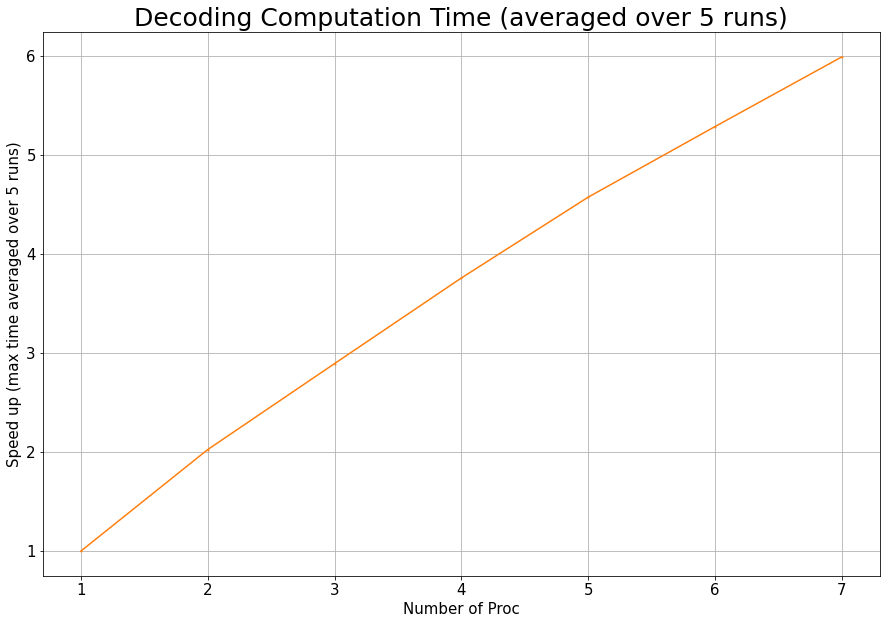

In [14]:
import numpy as np
import matplotlib.pyplot as plt

with open('times.txt', 'r') as the_file:
    time_list_s = the_file.readlines()
time_array = np.array([0.] * len(pr_nums))
for s in time_list_s:
    time_array[int(s[0]) - 1] += float(s[2:-2])

plt.figure(figsize = (15,10))
plt.title("Decoding Computation Time (averaged over 5 runs)", fontsize = 25)
plt.plot(pr_nums, time_array[0]/time_array , marker='o', color='C1', markersize = 1)
plt.grid()
plt.xlabel("Number of Proc",fontsize = 15)
plt.ylabel("Speed up (max time averaged over 5 runs)", fontsize = 15)
plt.tick_params(axis='both', labelsize=15)
plt.savefig(f"./Decoding Computation Time Speed-Up(averaged over 5 runs).png", dpi = 200, 
        bbox_inches = 'tight', facecolor = 'w',edgecolor= 'w')
plt.show()